In [1]:
import os
import re
import math
import pickle
import numpy as np
import pandas as pd

from tqdm import tqdm
from scipy.special import softmax
from utils import denoise_text, preprocess_text

from sklearn.utils.class_weight import compute_class_weight 
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

from matplotlib import pyplot as plt
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay)

from IPython.display import display, Markdown, Latex

In [2]:
PATH = "../datasets/"

## Data

In [3]:
data = pd.read_csv(PATH + "cards_waterloo.csv", low_memory=False)
data = data[data.DATASET.isin(["cards", "waterloo"])]
data.sample()

,prompt,claim,PARTITION,labels,sentiment,tweetid,roberta_preprocessed,roberta_pred,roberta_proba,DATASET,...,bertweet_pred,bertweet_proba,gpt-3_curie_pred,gpt-3_curie_proba,electra_pred,electra_proba,xlnet_pred,xlnet_proba,electra_acc_pred,electra_acc_proba
22121,Early Global Warming coincided with a slight i...,2_3,TRAIN,1,NaN,NaN,NaN,NaN,NaN,cards,...,1,"[0.0014658127911388874, 0.9985342025756836]",1,0.952846,1,"[0.05471523478627205, 0.9452847242355347]",1,"[0.0009379877592436969, 0.9990620017051697]",1,"[0.07348055392503738, 0.9265194535255432]"


In [4]:
data.DATASET.value_counts()

waterloo    43943
cards       28945
Name: DATASET, dtype: int64

In [5]:
def format_scores(x):
    return np.array(eval(re.sub(" +", " ,", x.replace("\n", ""))))

data["cards_proba"] = data["cards_proba"].apply(format_scores)
data["waterloo_proba"] = data["waterloo_proba"].apply(format_scores)
data["waterloo-cards_proba"] = data["waterloo-cards_proba"].apply(format_scores)

In [6]:
test = data[data.PARTITION=="TEST"]

## TEST METRICS
### General Metrics

**CARDS**

Accuracy: 0.9017673653925196
AUC: 0.9201573525696802
                    precision    recall  f1-score   support

Not Misinformation       0.93      0.95      0.94      5750
    Misinformation       0.79      0.73      0.76      1549

          accuracy                           0.90      7299
         macro avg       0.86      0.84      0.85      7299
      weighted avg       0.90      0.90      0.90      7299



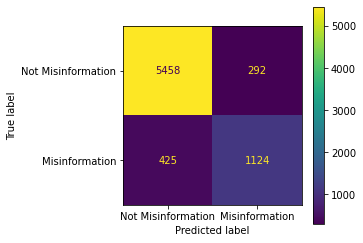

In [7]:
def report(y_true, y_pred, scores,  classes):
    
    acc = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, scores, multi_class="ovr", average="macro")

    print(f"Accuracy: {acc}")
    print(f"AUC: {roc_auc}")
    print(classification_report(y_true, y_pred, target_names=classes))
    c_m = confusion_matrix(y_true, y_pred)
    cmp = ConfusionMatrixDisplay(
        c_m, display_labels=classes)
    fig, ax = plt.subplots(figsize=(4,4))
    cmp.plot(ax=ax)  
    
target_names = ["Not Misinformation", "Misinformation"]
display(Markdown("**CARDS**"))
scores = test['cards_proba'].apply(lambda x: sum(x[1:]))
report(test.labels, test['cards_pred'], scores, target_names)

**WATERLOO**

Accuracy: 0.8490204137553089
AUC: 0.8806229545008001
                    precision    recall  f1-score   support

Not Misinformation       0.86      0.96      0.91      5750
    Misinformation       0.75      0.44      0.55      1549

          accuracy                           0.85      7299
         macro avg       0.81      0.70      0.73      7299
      weighted avg       0.84      0.85      0.83      7299



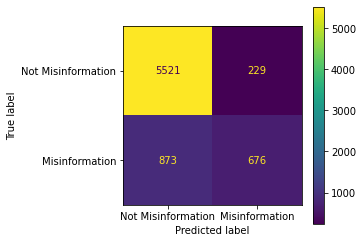

In [8]:
display(Markdown("**WATERLOO**"))
scores = test['waterloo_proba'].apply(lambda x: sum(x[1:]))
report(test.labels, test['waterloo_pred'], scores, target_names)

**WATERLOO-CARDS**

Accuracy: 0.9341005617207837
AUC: 0.9715538215398434
                    precision    recall  f1-score   support

Not Misinformation       0.95      0.97      0.96      5750
    Misinformation       0.88      0.80      0.84      1549

          accuracy                           0.93      7299
         macro avg       0.91      0.88      0.90      7299
      weighted avg       0.93      0.93      0.93      7299



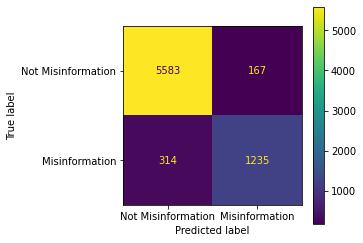

In [9]:
display(Markdown("**WATERLOO-CARDS**"))
scores = test['waterloo-cards_proba'].apply(lambda x: sum(x[1:]))
report(test["labels"], test['waterloo-cards_pred'], scores, target_names)

### Over Waterloo Segment

In [10]:
test_waterloo = data[(data.PARTITION=="TEST") & (data.DATASET=="waterloo")]

**CARDS waterloo segment**

Accuracy: 0.8996587030716724
AUC: 0.79030847890497
                    precision    recall  f1-score   support

Not Misinformation       0.94      0.95      0.95      3996
    Misinformation       0.44      0.40      0.42       399

          accuracy                           0.90      4395
         macro avg       0.69      0.67      0.68      4395
      weighted avg       0.90      0.90      0.90      4395



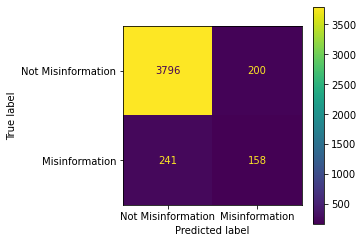

In [11]:
display(Markdown("**CARDS waterloo segment**"))
scores = test_waterloo['cards_proba'].apply(lambda x: sum(x[1:]))
report(test_waterloo.labels, test_waterloo['cards_pred'], scores, target_names)

**WATERLOO waterloo segment**

Accuracy: 0.9610921501706484
AUC: 0.9751991966904247
                    precision    recall  f1-score   support

Not Misinformation       0.98      0.98      0.98      3996
    Misinformation       0.79      0.77      0.78       399

          accuracy                           0.96      4395
         macro avg       0.89      0.88      0.88      4395
      weighted avg       0.96      0.96      0.96      4395



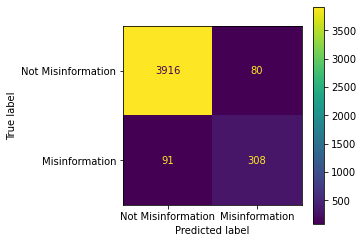

In [12]:
display(Markdown("**WATERLOO waterloo segment**"))
scores = test_waterloo['waterloo_proba'].apply(lambda x: sum(x[1:]))
report(test_waterloo.labels, test_waterloo['waterloo_pred'], scores, target_names)

**WATERLOO-CARDS in waterloo segment**

Accuracy: 0.9581342434584755
AUC: 0.9695234081198993
                    precision    recall  f1-score   support

Not Misinformation       0.98      0.98      0.98      3996
    Misinformation       0.77      0.76      0.77       399

          accuracy                           0.96      4395
         macro avg       0.87      0.87      0.87      4395
      weighted avg       0.96      0.96      0.96      4395



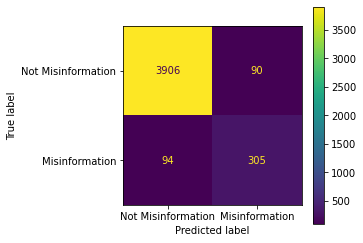

In [13]:
display(Markdown("**WATERLOO-CARDS in waterloo segment**"))
scores = test_waterloo['waterloo-cards_proba'].apply(lambda x: sum(x[1:]))
report(test_waterloo["labels"], test_waterloo['waterloo-cards_pred'], scores, target_names)

### Over CARDS segment

In [14]:
test_cards = data[(data.PARTITION=="TEST") & (data.DATASET=="cards")]

**CARDS in cards segment**

Accuracy: 0.9049586776859504
AUC: 0.9634829706013585
                    precision    recall  f1-score   support

Not Misinformation       0.90      0.95      0.92      1754
    Misinformation       0.91      0.84      0.87      1150

          accuracy                           0.90      2904
         macro avg       0.91      0.89      0.90      2904
      weighted avg       0.91      0.90      0.90      2904



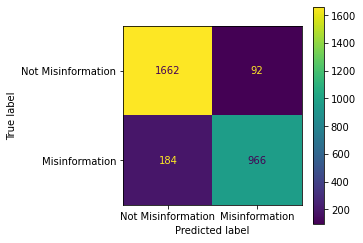

In [15]:
display(Markdown("**CARDS in cards segment**"))
scores = test_cards['cards_proba'].apply(lambda x: sum(x[1:]))
report(test_cards.labels, test_cards['cards_pred'], scores, target_names)

**WATERLOO waterloo segment**

Accuracy: 0.6794077134986226
AUC: 0.7067894502007833
                    precision    recall  f1-score   support

Not Misinformation       0.67      0.92      0.78      1754
    Misinformation       0.71      0.32      0.44      1150

          accuracy                           0.68      2904
         macro avg       0.69      0.62      0.61      2904
      weighted avg       0.69      0.68      0.64      2904



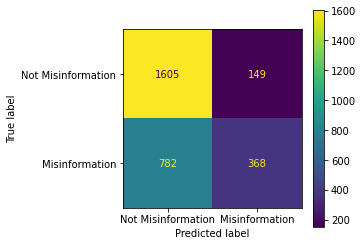

In [16]:
display(Markdown("**WATERLOO waterloo segment**"))
scores = test_cards['waterloo_proba'].apply(lambda x: sum(x[1:]))
report(test_cards.labels, test_cards['waterloo_pred'], scores, target_names)

**WATERLOO-CARDS in cards segment**

Accuracy: 0.8977272727272727
AUC: 0.961584700808091
                    precision    recall  f1-score   support

Not Misinformation       0.88      0.96      0.92      1754
    Misinformation       0.92      0.81      0.86      1150

          accuracy                           0.90      2904
         macro avg       0.90      0.88      0.89      2904
      weighted avg       0.90      0.90      0.90      2904



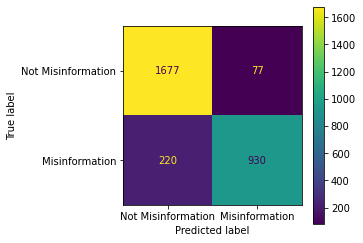

In [17]:
display(Markdown("**WATERLOO-CARDS in cards segment**"))
scores = test_cards['waterloo-cards_proba'].apply(lambda x: sum(x[1:]))
report(test_cards["labels"], test_cards['waterloo-cards_pred'], scores, target_names)

## Sample Labeled

In [18]:
sample_labeled = pd.read_csv(PATH + "hamburg/hamburg_1000_sample.csv")
sample_labeled = sample_labeled[~sample_labeled.label.isna()]
# sample_labeled["cards_pred_score"] = sample_labeled["cards_pred_score"].apply(format_scores)
# sample_labeled["waterloo_proba"] = sample_labeled["waterloo_proba"].apply(format_scores)
# sample_labeled["waterloo-cards_proba"] = sample_labeled["waterloo-cards_proba"].apply(format_scores)
sample_labeled.sample()

,id,username,fulltext,label,140_char_text,hashtags,url,domain,retweet_count,favorite_count,...,month,day,hour,minute,cards_pred,cards_pred_score,waterloo_cards_pred,waterloo_cards_score,date,cards_sum_pred
737,1594049962727407618,Henry_Keating87,@Leviathan_100 @tg6gkhmpt9 @fraseringram11 @Sa...,0_0,@Leviathan_100 @tg6gkhmpt9 @fraseringram11 @Sa...,[],NaN,NaN,0.0,0.0,...,11.0,19.0,19.0,28.0,0_0,0.999748,0,0.999959,2022-11-19,0


In [19]:
def remove_third_level(label):
    if label and isinstance(label, str):
        return re.match("\d_\d", label)[0]
    return 

sample_labeled["label_edit"] = sample_labeled["label"].apply(remove_third_level)

sample_labeled.loc[sample_labeled["label"] == "0_0", "binary_label"] = 0
sample_labeled.loc[sample_labeled["label"] != "0_0", "binary_label"] = 1

**CARDS**

Accuracy: 0.8170865279299014
AUC: 0.23673372620741043
                    precision    recall  f1-score   support

Not Misinformation       0.83      0.95      0.89       703
    Misinformation       0.69      0.37      0.48       210

          accuracy                           0.82       913
         macro avg       0.76      0.66      0.69       913
      weighted avg       0.80      0.82      0.80       913



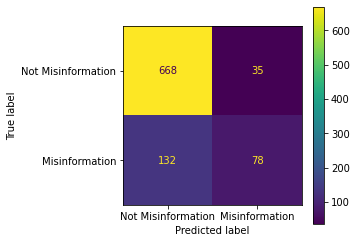

In [20]:
target_names = ["Not Misinformation", "Misinformation"]
# scores = sample_labeled.apply(
#     lambda x: x['cards_proba'][0] if x['cards_pred'] == "0_0" else sum(x['cards_proba'][1:]), axis=1)
display(Markdown("**CARDS**"))
report(sample_labeled["binary_label"], sample_labeled['cards_sum_pred'], 
       sample_labeled["cards_pred_score"], target_names)

**WATERLOO**

Accuracy: 0.8619934282584885
AUC: 0.1486723565670934
                    precision    recall  f1-score   support

Not Misinformation       0.88      0.94      0.91       703
    Misinformation       0.76      0.59      0.66       210

          accuracy                           0.86       913
         macro avg       0.82      0.77      0.79       913
      weighted avg       0.86      0.86      0.86       913



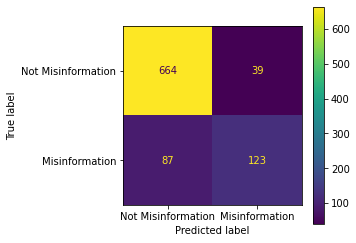

In [21]:
target_names = ["Not Misinformation", "Misinformation"]
# scores = sample_labeled.waterloo_proba.apply(
#     lambda x: x[1])
display(Markdown("**WATERLOO**"))
report(sample_labeled["binary_label"], sample_labeled['waterloo_cards_pred'], 
       sample_labeled["waterloo_cards_score"], target_names)

**WATERLOO-CARDS**

Accuracy: 0.8619934282584885
AUC: 0.1486723565670934
                    precision    recall  f1-score   support

Not Misinformation       0.88      0.94      0.91       703
    Misinformation       0.76      0.59      0.66       210

          accuracy                           0.86       913
         macro avg       0.82      0.77      0.79       913
      weighted avg       0.86      0.86      0.86       913



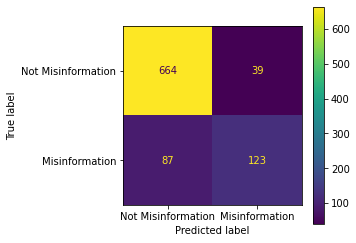

In [22]:
target_names = ["Not Misinformation", "Misinformation"]
# scores = sample_labeled["waterloo-cards_proba"].apply(
#     lambda x: x[1])
display(Markdown("**WATERLOO-CARDS**"))
report(sample_labeled["binary_label"], sample_labeled['waterloo_cards_pred'], 
       sample_labeled["waterloo_cards_score"], target_names)

**CARDS**

Accuracy: 0.7820372398685652
              precision    recall  f1-score   support

         0_0       0.83      0.95      0.89       703
         1_0       1.00      0.00      0.00         6
         1_3       1.00      0.00      0.00         4
         1_4       0.50      1.00      0.67         1
         1_6       1.00      0.00      0.00         2
         1_7       0.50      0.25      0.33         8
         1_8       1.00      0.00      0.00         5
         2_1       0.88      0.70      0.78        20
         2_3       0.33      0.67      0.44         3
         3_0       1.00      0.00      0.00        12
         3_1       0.00      1.00      0.00         0
         3_2       0.25      1.00      0.40         1
         3_4       1.00      0.00      0.00         1
         3_6       1.00      0.00      0.00         1
         4_1       0.46      0.38      0.41        16
         4_2       0.00      0.00      0.00         5
         4_3       1.00      0.00      0.00         

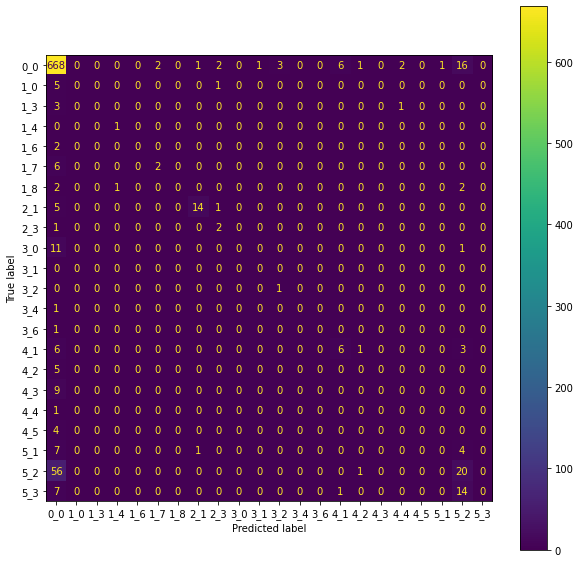

In [23]:
def report(y_true, y_pred, classes=None, size=(4,4)):
    
    acc = accuracy_score(y_true, y_pred)    
    print(f"Accuracy: {acc}")
    print(classification_report(y_true, y_pred, target_names=classes, zero_division=True))
    c_m = confusion_matrix(y_true, y_pred)
    cmp = ConfusionMatrixDisplay(
        c_m, display_labels=classes)
    fig, ax = plt.subplots(figsize=size)
    cmp.plot(ax=ax)
    
display(Markdown("**CARDS**"))

target_names = np.union1d(sample_labeled["label_edit"], sample_labeled["cards_pred"])
report(sample_labeled["label_edit"], sample_labeled['cards_pred'], target_names, size=(10, 10))

## Overall Comparisons

In [24]:
sample_labeled_ruby = pd.read_excel(PATH + "hamburg/Ruby_1000_tweets.xlsx")
sample_labeled_ruby.loc[sample_labeled_ruby["label"] == '0.0.0 ', "binary_label"] = 0
sample_labeled_ruby.loc[sample_labeled_ruby["label"] != '0.0.0 ', "binary_label"] = 1
sample_labeled_ruby.binary_label.value_counts()

joinedsample = sample_labeled.join(sample_labeled_ruby[["id", "binary_label"]].set_index("id"), 
                    on="id", how="inner", lsuffix='_john', rsuffix='_ruby')

inner_joinedsample = joinedsample[joinedsample.binary_label_john == joinedsample.binary_label_ruby]
inner_joinedsample = inner_joinedsample.rename(
    columns={"label": "original_label", "binary_label_john":"labels", 
             "cards_pred": "taxonomy_cards_pred", "cards_sum_pred": "cards_pred", 
             "waterloo_cards_pred": "waterloo-cards_pred"})

In [25]:
models = ["cards", "waterloo-cards"]
datasets = [test_cards, test_waterloo, inner_joinedsample]
index = ["CARDS", "Waterloo", "Hamburg Sample"]
inner_joinedsample["labels"]
comparative = pd.DataFrame()

for j, d in enumerate(datasets):
    scores = []
    for i, m in enumerate(models):
        score = f1_score(d["labels"], d[f"{m}_pred"], average="macro")
        scores.append(score)
    comparative = pd.concat([comparative, pd.Series(scores)], ignore_index=True, axis=1)
        
comparative = comparative.T
comparative.columns = ["CARDS", "CARDS + Waterloo"]
comparative.index = index
comparative["Support"] = test.DATASET.value_counts().tolist() + [inner_joinedsample.shape[0]]
comparative

,CARDS,CARDS + Waterloo,Support
CARDS,0.899167,0.890481,4395
Waterloo,0.681269,0.872625,2904
Hamburg Sample,0.740956,0.837040,770
